# IBM Capstone final project - Battle of the Neighborhood

This project is designed such a way it doesn’t take lot of time from my current work life. So, this going to be a simple project without much assumptions or pushing the limits.

## Problem statement:
A Multinational Company X wants to setup its first branch in India. The choice of the place where the company is going to setup will depend on the venues in that area. In order to identify the ideal place, the company is interested to do analysis on the Central Business Districts (or CBD in short) of India. The Company has many businesses and wants to keep the identity confidential. The analyst doesn’t know for which business the company are picking the place to remove any bias from the analysis. So, the company profile or type of business or any other information is unknown.

### The outline of the objectives:
    • Identify the CBDs in India
    • Collect the venue data of the CBDs.
    • Perform a clustering analysis among the CBD to identify the similar groups
    • Profile the clusters based on the analysis

## Preparing the Dataset for the Analysis
### Importing the necessary libraries

In [17]:
import pandas as pd
import numpy as np
import json
import requests 
from pandas.io.json import json_normalize
import bs4
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.cluster import AgglomerativeClustering 
import matplotlib
import scipy
import scipy.cluster.hierarchy
from collections import Counter
import folium
#from geopy.geocoders import Nominatim
#from geopy import geocoders

The wiki website we are going to scrape the table from https://en.wikipedia.org/wiki/List_of_central_business_districts

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_central_business_districts'

results = requests.get(url)
wiki = bs4.BeautifulSoup(results.text,"lxml")
wiki_data = wiki.find_all('table',{'class':'sortable wikitable'})
wiki_Asia = wiki_data[1]
City = []
Country = []
CBD = []
count = 1
for table in wiki_Asia.find_all('td'):
    text = table.text.strip()
    if count%3 == 1:
        City.append(text)
    elif count%3 == 2:
        Country.append(text)
    elif count%3 == 0:
        CBD.append(text)
    count = count+1
    if text == "West Bank":
        CBD.append(text)
        count = count + 1

Creating a Dataframe from the scrapped list variables and cleaning the dataset for further use

In [3]:
df = pd.DataFrame(list(zip(City, Country, CBD)), columns =['City', 'Country', 'CBD'])
df_India = df[df['Country']=="India"]
print(df_India.shape)
df_India['CBD'] = df_India.apply(lambda x: x['CBD'].replace("and ", ", "), axis=1)
df_India['CBD'] = df_India.apply(lambda x: x['CBD'].replace("MG Road", "MG Road,"), axis=1)
df_India['CBD'] = df_India.apply(lambda x: x['CBD'].replace("Edappally", "Edappally,"), axis=1)
df_India['CBD'] = df_India.apply(lambda x: x['CBD'].replace("Nariman Point", "Nariman Point,"), axis=1)
df_India['CBD'] = df_India.apply(lambda x: x['CBD'].replace("Cuffe Parade", "Cuffe Parade,"), axis=1)
df_India

(12, 3)


/home/batman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/batman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/batman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,City,Country,CBD
0,Ahmedabad and Gandhinagar,India,Gujarat International Finance Tec-City
3,Bangalore,India,"MG Road, Shivajinagar, Bangalore Central Busin..."
11,Chandigarh,India,Sector 17
12,Chennai,India,"Anna Salai, T Nagar, Parry's Corner, Nungambakkam"
14,Coimbatore,India,"Avinashi Road, Gandhipuram, RS Puram"
37,Hyderabad,India,"Nampally, HITEC City, Nanakramguda, Manikonda,..."
48,Kochi,India,"Area around M.G Road, Edappally, Lulu Internat..."
49,Kolkata,India,"Located in B.B.D. Bagh , Esplanade"
56,Mumbai and Navi Mumbai,India,"Ballard Estate, Nariman Point, Cuffe Parade, C..."
58,New Delhi,India,"Connaught Place, Nehru Place"


Currently as you can see in the above table that the CBDs that we want to do the analysis is separated by commas, so in the next cell we are creating a stacked dataset and cleaning the dataset further

In [4]:
def stack_CBD(country, city, string ):
    country_list = []
    city_list = []
    CBD_list = []
    for i in range(0, len(country)):
        country_element = country[i]
        city_element = city[i]
        string_element = string[i]
        for item in string_element.split(','):
            country_list.append(country_element)
            city_list.append(city_element)
            CBD_list.append(item)

    df_temp = pd.DataFrame(list(zip(city_list, country_list, CBD_list)), columns =['City', 'Country', 'CBD'])
    return(df_temp)
stacked_df = stack_CBD(df_India['Country'].values.tolist(), df_India['City'].values.tolist(), df_India['CBD'].values.tolist())
stacked_df = stacked_df[stacked_df['CBD']!=""]
stacked_df['CBD'] = stacked_df.apply(lambda x: x['CBD'].replace("Located in ", ""), axis=1)
stacked_df['CBD'] = stacked_df.apply(lambda x: x['CBD'].replace("Area around ", ""), axis=1)
stacked_df

,City,Country,CBD
0,Ahmedabad and Gandhinagar,India,Gujarat International Finance Tec-City
1,Bangalore,India,MG Road
2,Bangalore,India,Shivajinagar
3,Bangalore,India,Bangalore Central Business District
4,Bangalore,India,Electronic City
5,Bangalore,India,Whitefield
6,Chandigarh,India,Sector 17
7,Chennai,India,Anna Salai
8,Chennai,India,T Nagar
9,Chennai,India,Parry's Corner


There was some issue while using the geopy to get the latitudes and longitudes. So as the sample is just of 40 records. It is easy to add the location manually

In [25]:
stacked_cood = pd.read_csv("CBD_India_coordinates.csv")
stacked_cood

,City,Country,CBD,latitude,longitude
0,Ahmedabad and Gandhinagar,India,Gujarat International Finance Tec-City,23.158600,72.683100
1,Bangalore,India,B – MG Road,12.973800,77.611900
2,Bangalore,India,Shivajinagar,12.985700,77.605700
3,Bangalore,India,Bangalore Central Business District,12.972442,77.580643
4,Bangalore,India,Electronic City,12.845200,77.660200
5,Bangalore,India,Whitefield,12.969800,77.750000
6,Chandigarh,India,Sector 17,30.741100,76.779000
7,Chennai,India,Anna Salai,13.048786,80.249686
8,Chennai,India,T Nagar,13.041800,80.234100
9,Chennai,India,Parry's Corner,13.089600,80.288200


Lets Visualize the datapoints in Map of India

In [26]:
map_india = folium.Map(location=[20.5937, 78.9629], zoom_start=5)
for lat, lng, City, CBD in zip(stacked_cood['latitude'], stacked_cood['longitude'], stacked_cood['City'], stacked_cood['CBD']):
    label = '{}, {}'.format(City, CBD)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_india)  
    
map_india

In [27]:
#The code is deleted for sharing purposes

Using the Foursquare APi to get the necessary venue informations

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 1000):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CBD', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
df_venues = getNearbyVenues(names=stacked_cood['CBD'],
                            latitudes=stacked_cood['latitude'],
                            longitudes=stacked_cood['longitude']
                           )
df_venues.head(10)

,CBD,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gujarat International Finance Tec-City,23.1586,72.6831,"""Ken's Koffee++ GIFT City""",23.158295,72.684088,Café
1,Gujarat International Finance Tec-City,23.1586,72.6831,Gift City Club,23.160429,72.689896,Hotel
2,Gujarat International Finance Tec-City,23.1586,72.6831,Grand Mercure Gandhinagar Gift City,23.164967,72.687830,Hotel
3,B – MG Road,12.9738,77.6119,Arbor Brewing Company,12.970140,77.610857,Brewery
4,B – MG Road,12.9738,77.6119,Nagarjuna,12.973145,77.609263,Andhra Restaurant
5,B – MG Road,12.9738,77.6119,The Permit Room,12.970388,77.610358,Pub
6,B – MG Road,12.9738,77.6119,Smally's RestoCafe,12.974412,77.607234,Café
7,B – MG Road,12.9738,77.6119,Starbucks,12.974436,77.607308,Coffee Shop
8,B – MG Road,12.9738,77.6119,Chung Wah,12.974099,77.609386,Chinese Restaurant
9,B – MG Road,12.9738,77.6119,Art of Delight,12.973198,77.609254,Ice Cream Shop


## Exploratory data checks and preparing the dataset for modeling

The following is the number of vunues we got for every CBD

In [29]:
df_venues['CBD'].value_counts()

B – MG Road                               100
Nariman Point                             100
Nungambakkam                               94
Anna Salai                                 91
Connaught Place                            84
T Nagar                                    74
HITEC City                                 73
Ballard Estate                             70
East Fort                                  54
Bandra Kurla Complex                       52
Asilmetta                                  49
Electronic City                            44
Nehru Place                                43
Siripuram                                  40
RS Puram                                   39
Shivajinagar                               38
Edappally                                  37
Himayatnagar                               36
Lulu International Shopping Mall           36
Dwaraka Nagar                              35
Esplanade                                  34
T – MG Road                       

Distribution of the Venue categories

In [30]:
df_venues['Venue Category'].value_counts()

Indian Restaurant          219
Café                        98
Hotel                       95
Fast Food Restaurant        52
Coffee Shop                 51
                          ... 
Chocolate Shop               1
Metro Station                1
Volleyball Court             1
Health & Beauty Service      1
Yoga Studio                  1
Name: Venue Category, Length: 187, dtype: int64

Saving the Categories to check the full list

In [31]:
#Saving the datasets
df_venues.to_csv("Indian_CBD_venues.csv")

Now prepping the dataset for the models creating dummies for the models

In [36]:
df_dummies = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")
df_dummies['CBD'] = df_venues['CBD'] 
fixed_columns = [df_dummies.columns[-1]] + list(df_dummies.columns[:-1])
df_dummies = df_dummies[fixed_columns]
df_grouped = df_dummies.groupby('CBD').mean().reset_index()
df_grouped.to_csv("distance_check.csv")
df_grouped

,CBD,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,...,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Wine Bar,Women's Store,Yoga Studio
0,Anna Salai,0.000000,0.000000,0.010989,0.000000,0.010989,0.000000,0.000000,0.00,0.010989,...,0.010989,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.010989,0.000000
1,Asilmetta,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2,Avinashi Road,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.200000,0.0,0.000000,0.00,0.000000,0.000000
3,B – MG Road,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.010000,...,0.020000,0.00,0.02,0.000000,0.000000,0.0,0.000000,0.00,0.010000,0.000000
4,B.B.D. Bagh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.047619,0.0,0.000000,0.00,0.000000,0.000000
5,Ballard Estate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.028571,0.014286,0.0,0.000000,0.00,0.000000,0.000000
6,Bandra Kurla Complex,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.019231,0.00,0.00,0.000000,0.019231,0.0,0.000000,0.00,0.000000,0.019231
7,Bangalore Central Business District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
8,CBD Belapur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.086957,0.043478,0.0,0.000000,0.00,0.000000,0.000000
9,Colaba,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000


## Modeling stage

Our choice of the clustering model is Agglomerative Hierarchical clustering. In Agglomerative or bottom-up clustering method, in the starting stage each observation is assigned to its own cluster. Then, compute the similarity (e.g., distance) between each of the clusters and join the two most similar clusters. Finally, repeat the steps until there is only a single cluster left. 

There are two advantages of this algorithm. 
    1. Euclidean distance is a good measure of the similarity in this case.
    2. Client can choose any place that is closest to the ideal branch from the dendrogram.

In [37]:
x = df_grouped.drop(columns=['CBD']).values 
leng = x.shape[0]
D = np.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(x[i], x[j])

In [38]:
Z = hierarchy.linkage(D, 'complete')
from scipy.cluster.hierarchy import fcluster
k = 8
clusters = fcluster(Z, k, criterion='maxclust')
Counter(clusters)

/home/batman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


Counter({2: 20, 3: 3, 1: 11, 4: 2, 5: 1, 6: 1, 8: 1, 7: 1})

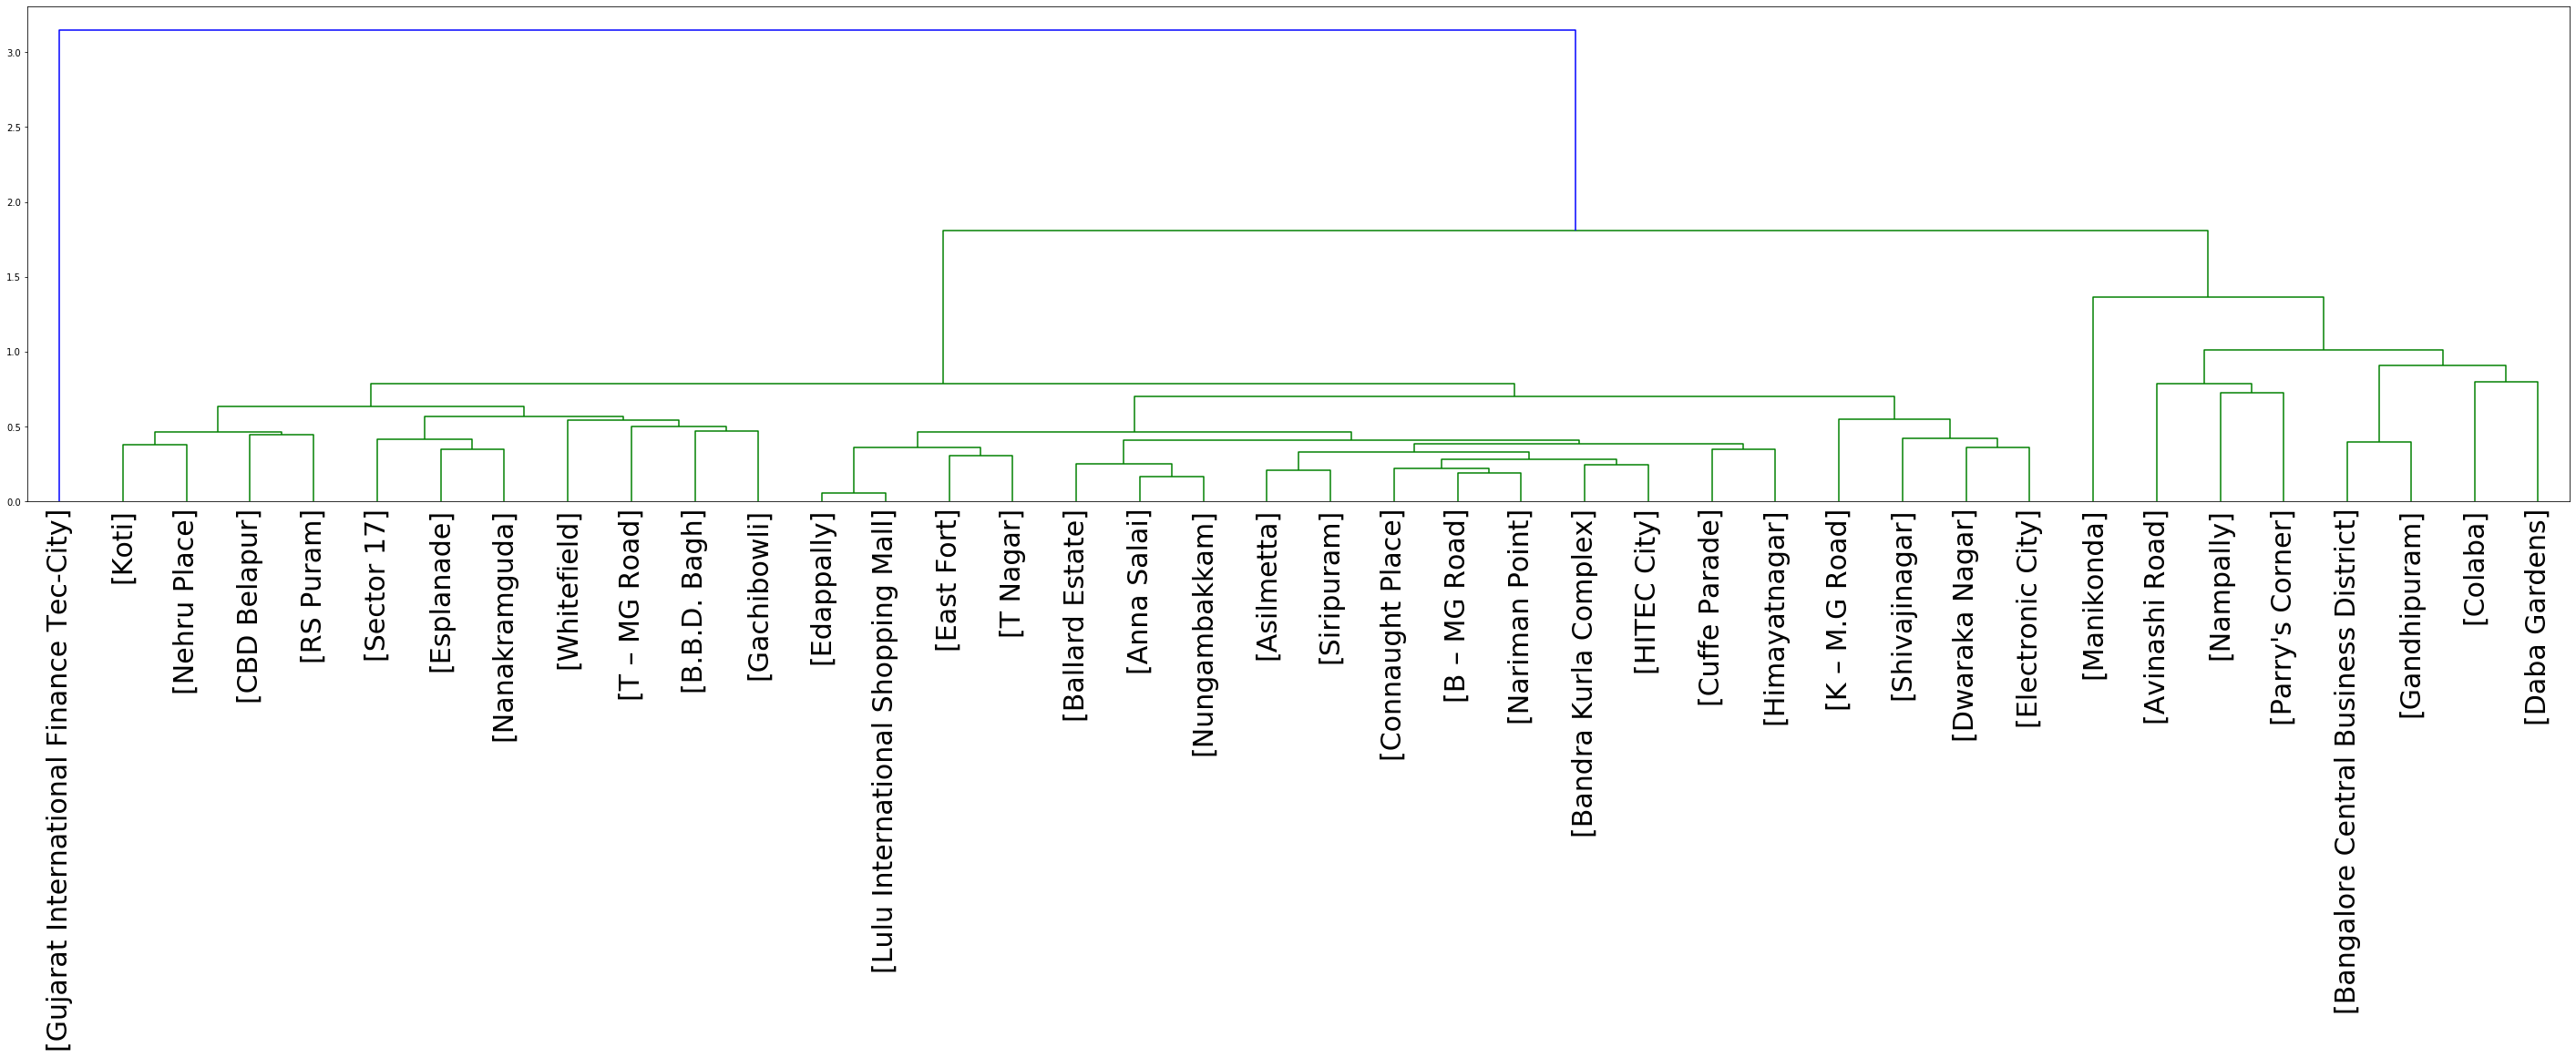

In [39]:
fig = pylab.figure(figsize=(50,10))
def llf(id):
    return '[%s]' % (df_grouped['CBD'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=90, leaf_font_size =30)

Adding the clusters to a dataset and saving the dataset for futher analysis

In [41]:
df_merged_final = stacked_cood.sort_values(by=['CBD'])
df_merged_final.insert(0, 'Cluster Labels', clusters)
df_merged_final = df_merged_final.join(df_grouped.set_index('CBD'), on='CBD')

df_merged_final.head(10) 

df_merged_final.to_csv('Final output.csv')

Visualising the final clusters

In [45]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[20.5937, 78.9629], zoom_start=5)
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_final['latitude'], df_merged_final['longitude'], df_merged_final['CBD'], df_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters